In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(300, 4)
        
    def forward(self, x):
        x = self.fc1(x)
        return x

<IPython.core.display.Javascript object>


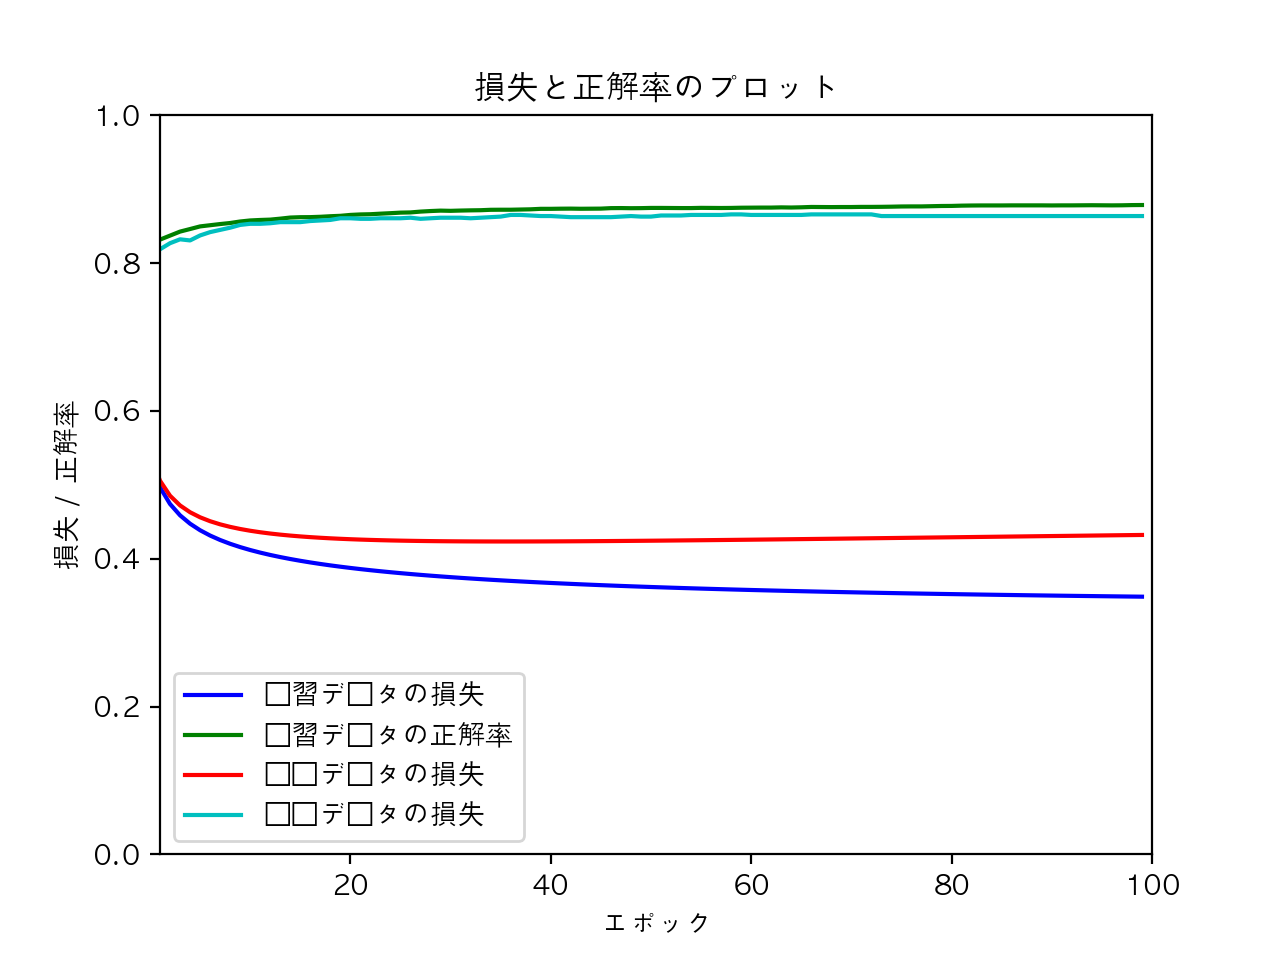

In [2]:
%matplotlib nbagg

import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'AppleGothic'
from matplotlib import animation

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=pow(10, -2)) # lr: 検証の結果、100エポック目で最も精度が高かった数値

queue_x = torch.from_numpy(np.load('results/70_result_queue_x_train.npy')).float()
queue_y = torch.from_numpy(np.load('results/70_result_queue_y_train.npy')).long()
dataset = torch.utils.data.TensorDataset(queue_x, queue_y)
dataloader = torch.utils.data.DataLoader(dataset)
queue_x_valid = torch.from_numpy(np.load('results/70_result_queue_x_valid.npy')).float()
queue_y_valid = torch.from_numpy(np.load('results/70_result_queue_y_valid.npy')).long()
X = []
Y_train_loss = []
Y_train_accuracy = []
Y_valid_loss = []
Y_valid_accuracy = []

def update(epoch):
    plt.cla()
    
    for data in dataloader:
        x, y = data
        optimizer.zero_grad()
        pre_y = net(x)
        loss = criterion(pre_y, y)
        loss.backward()
        optimizer.step()
        
    pre_queue_y = net(queue_x)
    loss_train = criterion(pre_queue_y, queue_y)
    pre_labels = torch.max(pre_queue_y, 1)[1]
    accuracy_train = (pre_labels == queue_y).sum().item() / len(queue_y)
    pre_queue_y_valid = net(queue_x_valid)
    loss_valid = criterion(pre_queue_y_valid, queue_y_valid)
    pre_labels = torch.max(pre_queue_y_valid, 1)[1]
    accuracy_valid = (pre_labels == queue_y_valid).sum().item() / len(queue_y_valid)
    
    X.append(epoch)
    Y_train_loss.append(loss_train)
    Y_train_accuracy.append(accuracy_train)
    Y_valid_loss.append(loss_valid)
    Y_valid_accuracy.append(accuracy_valid)
    
    plt.plot(X, Y_train_loss, color='b', label='学習データの損失')
    plt.plot(X, Y_train_accuracy, color='g', label='学習データの正解率')
    plt.plot(X, Y_valid_loss, color='r', label='検証データの損失')
    plt.plot(X, Y_valid_accuracy, color='c', label='検証データの損失')
    plt.xlim(xmin=1, xmax=100)
    plt.ylim(ymin=0, ymax=1)
    plt.title('損失と正解率のプロット')
    plt.xlabel('エポック')
    plt.ylabel('損失 / 正解率')
    plt.legend()
    
    if epoch % 20 == 19: # ファイル数が多くなりすぎるため、20エポック毎に書き出す
        fname = 'results/76_result_{0}.pth'.format(epoch + 1)
        torch.save(net.state_dict(), fname)
        
fig = plt.figure()
ani = animation.FuncAnimation(fig, update, frames=range(100), interval=1, repeat=None, blit=True)
plt.show()